Here we will be computing 10 day VAR for S&P500 and NASDAQ100. Output count of breaches, a plot, list of breaches, and describe which index was more volatile during pandemic outbreak and subsequent recovery period

In [ ]:
import sys
sys.path.append("../src")

import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Import custom modules
from data.fetch_data import fetch_and_save_data
from risk.var import historical_var, parametric_var, monte_carlo_var, calculate_daily_returns
from risk.utils import sharpe_ratio
from config import TICKERS, START_DATE, END_DATE, PROCESSED_DATA_DIR, CONFIDENCE_LEVEL, MONTE_CARLO_SIMULATIONS

# Optional styling
plt.style.use('ggplot')


ImportError: cannot import name 'calculate_daily_returns' from 'risk.utils' (/home/gusta/projects/VaR_exploration/notebooks/../src/risk/utils.py)

In [ ]:
# Load index return series, 
# setting date column to datetime format and setting as index column of dataframe
nq100 = pd.read_csv('nasdaq100_2024.csv', parse_dates = ['Date'], index_col = 'Date')
sp500 =pd.read_csv('sp500_2024.csv', parse_dates = ['Date'], index_col = 'Date')

In [22]:
# Calculate daily log returns
nq100['ret_log'] = np.log(nq100['Closing Price'] / nq100['Closing Price'].shift(1))
sp500['ret_log'] = np.log(sp500['Closing Price'] / sp500['Closing Price'].shift(1))

# Calculate 10 day forward log returns
nq100['ret_10d'] = np.log(nq100['Closing Price'].shift(-10) / nq100['Closing Price'])
sp500['ret_10d'] = np.log(sp500['Closing Price'].shift(-10) / sp500['Closing Price'])

# Calculate 21 day rolling standard deviation of the log returns
nq100['std_21'] = nq100['ret_log'].rolling(window=21).std()
sp500['std_21'] = sp500['ret_log'].rolling(window=21).std()

# Calculate 99% VaR, the left tail cutoff is approx z = -2.33
nq100['var_10d'] = -2.33 * 10 ** 0.5 * nq100['std_21']
sp500['var_10d'] = -2.33 * 10 ** 0.5 * sp500['std_21']

In [23]:
# Check where breaches occured by checking where return was lower than the calculacted var
nq100['breach'] = (nq100['ret_10d'] < nq100['var_10d']) & (nq100['ret_10d'] < 0)
sp500['breach'] = (sp500['ret_10d'] < sp500['var_10d']) & (sp500['ret_10d'] < 0)

In [ ]:
# Count and percentage VAR breaches per index
print('NASDAQ100 breaches count:', nq100['breach'][nq100['breach'] == True].count(),
      'Percentage breaches:', 
      round(nq100['breach'].mean(),3))
print('S&P500 breaches count:', sp500['breach'][sp500['breach'] == True].count(),
      'Percentage breaches:', 
      round(sp500['breach'].mean(),3))

NASDAQ100 breaches count: 43 Percentage breaches: 0.026
S&P500 breaches count: 61 Percentage breaches: 0.036


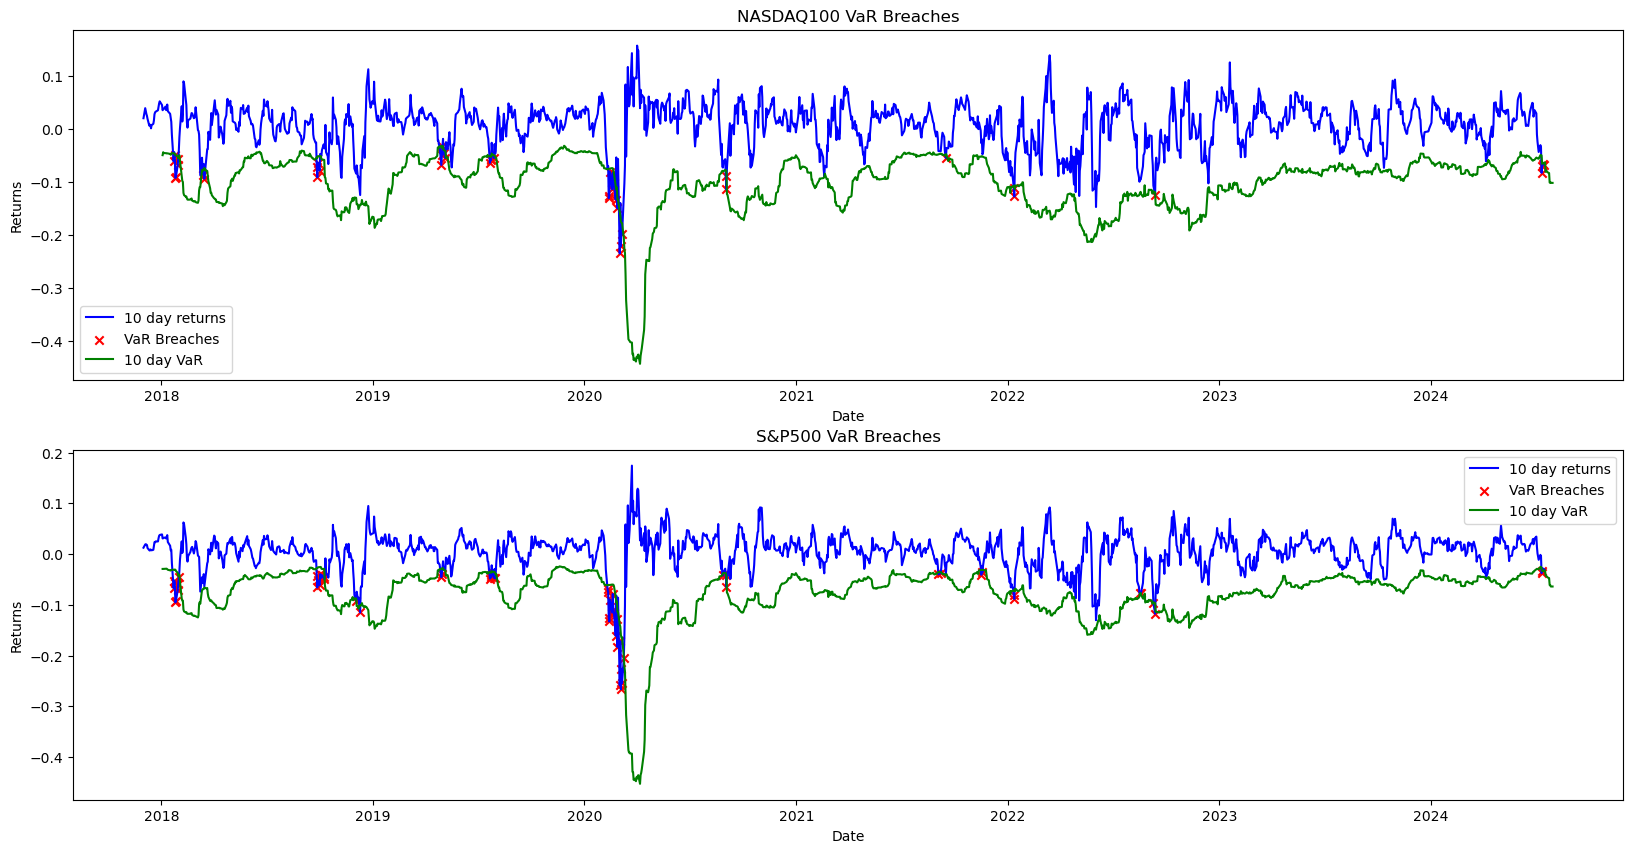

In [ ]:
# Import matplotlib to do the plotting
import matplotlib.pyplot as plt

# Create a function (will also be used for question 5) so we can create multiple graphs
def plot_var_breaches(data, title, breach, ax):
    # Plotting the 10-day returns
    ax.plot(data.index, data['ret_10d'], 
            label='10 day returns', 
            color='blue')
    
    # Creating a marker for breaches
    breaches = data[data[breach]]
    ax.scatter(breaches.index, breaches['ret_10d'],
               color='red', 
               marker='x', 
               label='VaR Breaches')
    
    # Plot the 10-day VAR
    ax.plot(data.index, data['var_10d'], 
            label='10 day VaR', 
            color='green')
    
    # Titles and labels
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Returns')
    ax.legend()

# Create two subplots so we can compare the S&P500 to the NASDAQ100 VAR breaches
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

# Plotting the two indeces
plot_var_breaches(nq100, 'NASDAQ100 VaR Breaches', 'breach', ax1)
plot_var_breaches(sp500, 'S&P500 VaR Breaches','breach', ax2)

# Display
plt.show()

In [ ]:
# NASDAQ100 list of VAR breaches
nq100_breach_table = nq100[['Closing Price', 'ret_log', 'var_10d', 'ret_10d', 'breach']]
print('NASDAQ100', nq100_breach_table[nq100_breach_table['breach']==True].head())

#S&P500 list of VAR breaches
sp500_breach_table = sp500[['Closing Price', 'ret_log', 'var_10d', 'ret_10d', 'breach']]
print('S&P500', sp500_breach_table[sp500_breach_table['breach']==True].head())

NASDAQ100             Closing Price   ret_log   var_10d   ret_10d  breach
Date                                                           
2018-01-22    6906.279785  0.010473 -0.045903 -0.061257    True
2018-01-24    6919.350098 -0.006355 -0.048418 -0.049980    True
2018-01-25    6916.299805 -0.000441 -0.048256 -0.092363    True
2018-01-26    7022.970215  0.015305 -0.049911 -0.090909    True
2018-01-29    6988.319824 -0.004946 -0.051699 -0.068775    True
S&P500             Closing Price   ret_log   var_10d   ret_10d  breach
Date                                                           
2018-01-22    2832.969971  0.008034 -0.031004 -0.067166    True
2018-01-23    2839.129883  0.002172 -0.030470 -0.052048    True
2018-01-24    2837.540039 -0.000560 -0.030917 -0.056502    True
2018-01-25    2839.250000  0.000602 -0.030674 -0.095363    True
2018-01-26    2872.870117  0.011772 -0.033248 -0.092309    True


In [ ]:
# Filter for only breaches
nq100_breach_table = nq100_breach_table[nq100_breach_table['breach']==True]
sp500_breach_table = sp500_breach_table[sp500_breach_table['breach']==True]

# Filter for covid period
nq100_covid_breaches = nq100_breach_table.loc['2020-02-01':'2020-03-31']
sp500_covid_breaches = sp500_breach_table.loc['2020-02-01':'2020-03-31']

# Filter for recovery Period
nq100_recovery_breaches = nq100_breach_table.loc['2021-01-01':'2022-12-31']
sp500_recovery_breaches = sp500_breach_table.loc['2021-01-01':'2022-12-31']

# Print number of breaches during each period
print('NASDAQ100 covid breaches:', len(nq100_covid_breaches),
      'Recovery breaches:', len(nq100_recovery_breaches))

# Print number of breaches during each period
print('S&P500 covid breaches:', len(sp500_covid_breaches), 
      'Recovery breaches:', len(sp500_recovery_breaches))

NASDAQ100 covid breaches: 12 Recovery breaches: 4
S&P500 covid breaches: 18 Recovery breaches: 10


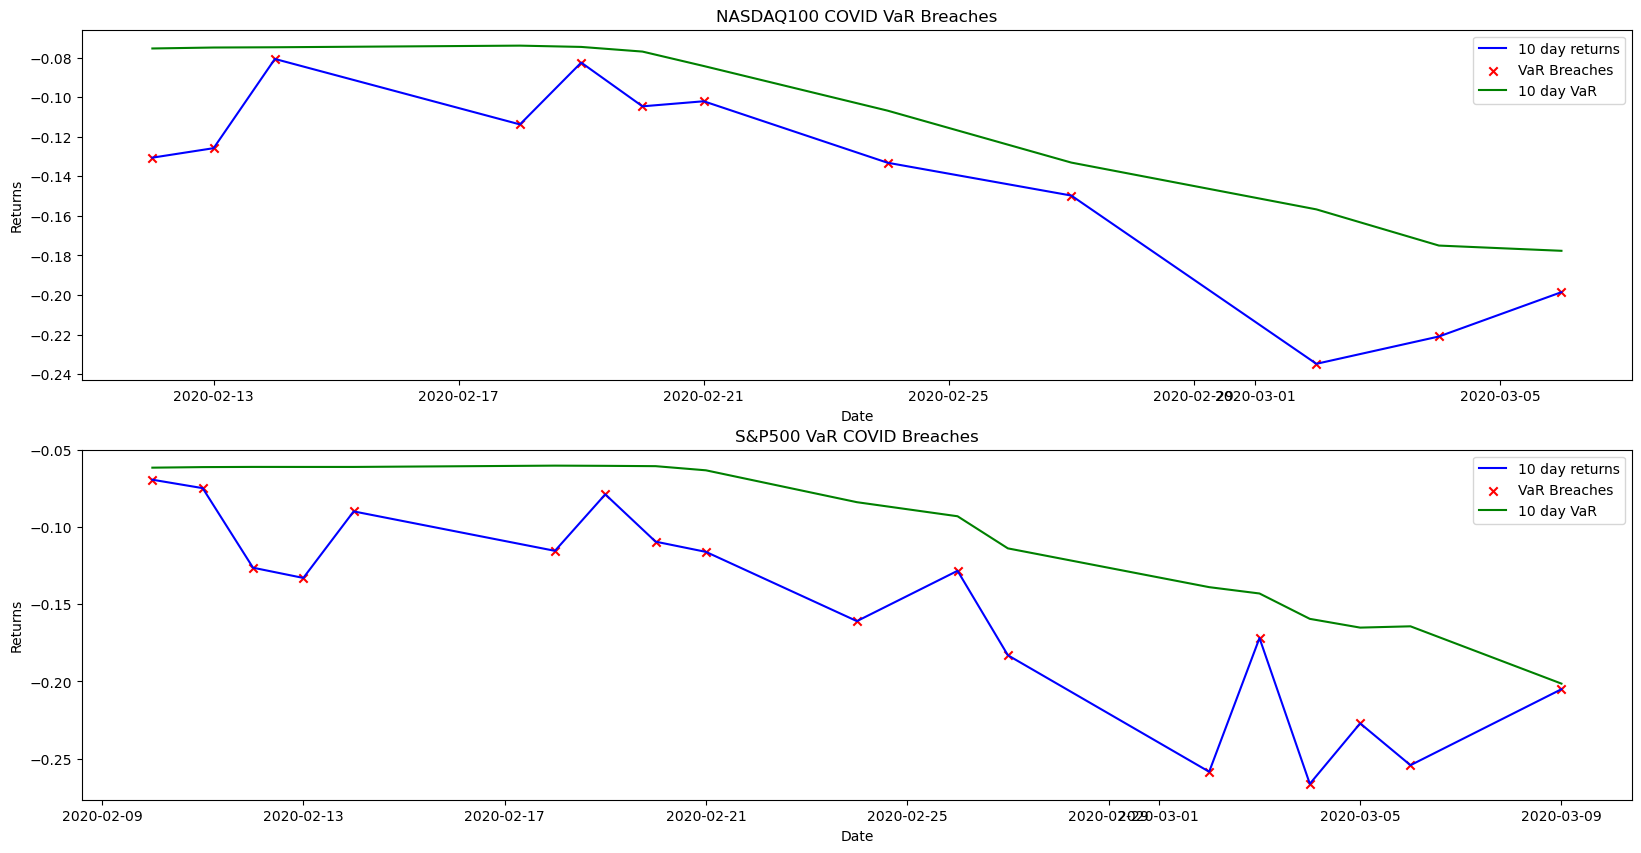

In [28]:
# Quick graph to inspect the covid period breaches
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

# Plotting the two indeces
plot_var_breaches(nq100_covid_breaches, 'NASDAQ100 COVID VaR Breaches', 'breach', ax1)
plot_var_breaches(sp500_covid_breaches, 'S&P500 VaR COVID Breaches','breach', ax2)

# Display
plt.show()

The S&P500 index appears more risky than the NASDAQ100 both during the covid period of february/march 2020 and the recovery period of 2021-2022. The S&P500 saw 50% more breaches in the 2 month span of the COVID outbreak, the S&P500 saw VaR breaches earlier in february than the NASDAQ, and also had twice as many breaches in early march.

Compared to the covid outbreak period of 2 months the recovery period defined as the 2 year period of 2021-2022 was much calmer, with both indices having much fewer breaches in this 2 year period than they did during 2 months of covid. But still here the NASDAQ appears less risky only having 4 breaches, 2 per year compared to the S&P500 10 breaches or 5 per year.

There is not enough information to draw a conclusion or inference based on this data. But an initial hypothesis is that the NASDAQ index as a tech heavy index might not be as negativly affected by covid given the peoples move to more digital lifes during lockdowns, in general technology stocks might not have been as hurt by the pandemic as other sectors since during lockdown people consumed technology more and more. It would from that perspective make sense for a tech heavy index such as NASDAQ to be less risky in such an event than a more general economy exposed index such as S&P500.

#### Now let's do the same analysis but use EWMA instead of 10 day VAR and also discuss the impact of lambda on the smoothness of EWMA

In [31]:
# Initialize the variance
nq100['EWMA'] = nq100['ret_log'].var()
sp500['EWMA'] = sp500['ret_log'].var()

# Calculate EWMA = lamda*previous day EWMA + (1-lambda) * (previous day return)^2
for i in range(1, len(nq100)):
        nq100.loc[nq100.index[i], 'EWMA'] = (0.72 * nq100['EWMA'].iloc[i-1] +
                                            (1 - 0.72) * nq100['ret_log'].iloc[i] ** 2)
for i in range(1, len(sp500)):
        sp500.loc[sp500.index[i], 'EWMA'] = (0.72 * sp500['EWMA'].iloc[i-1] + 
                                             (1 - 0.72) * sp500['ret_log'].iloc[i] ** 2)

In [32]:
# Calculate 99% var, the left tail cutoff is approx z = -2.33
nq100['ewma_10d'] = -2.33 * (10 * nq100['EWMA']) ** 0.5
sp500['ewma_10d'] = -2.33 * (10 * sp500['EWMA']) ** 0.5

# Check for breaches
nq100['breach_ewma'] = (nq100['ret_10d'] < nq100['ewma_10d']) & (nq100['ret_10d'] < 0)
sp500['breach_ewma'] = (sp500['ret_10d'] < sp500['ewma_10d']) & (sp500['ret_10d'] < 0)

In [ ]:
# Count and percentage VAR breaches per index
print('NASDAQ100 EWMA breaches count:', 
      nq100['breach_ewma'][nq100['breach_ewma'] == True].count(),
      'Percentage breaches:', 
      round(nq100['breach_ewma'].mean(),3))
print('S&P500 EWMA breaches count:', 
      sp500['breach_ewma'][sp500['breach_ewma'] == True].count(),
      'Percentage breaches:', 
      round(sp500['breach_ewma'].mean(),3))

NASDAQ100 EWMA breaches count: 53 Percentage breaches: 0.032
S&P500 EWMA breaches count: 66 Percentage breaches: 0.039


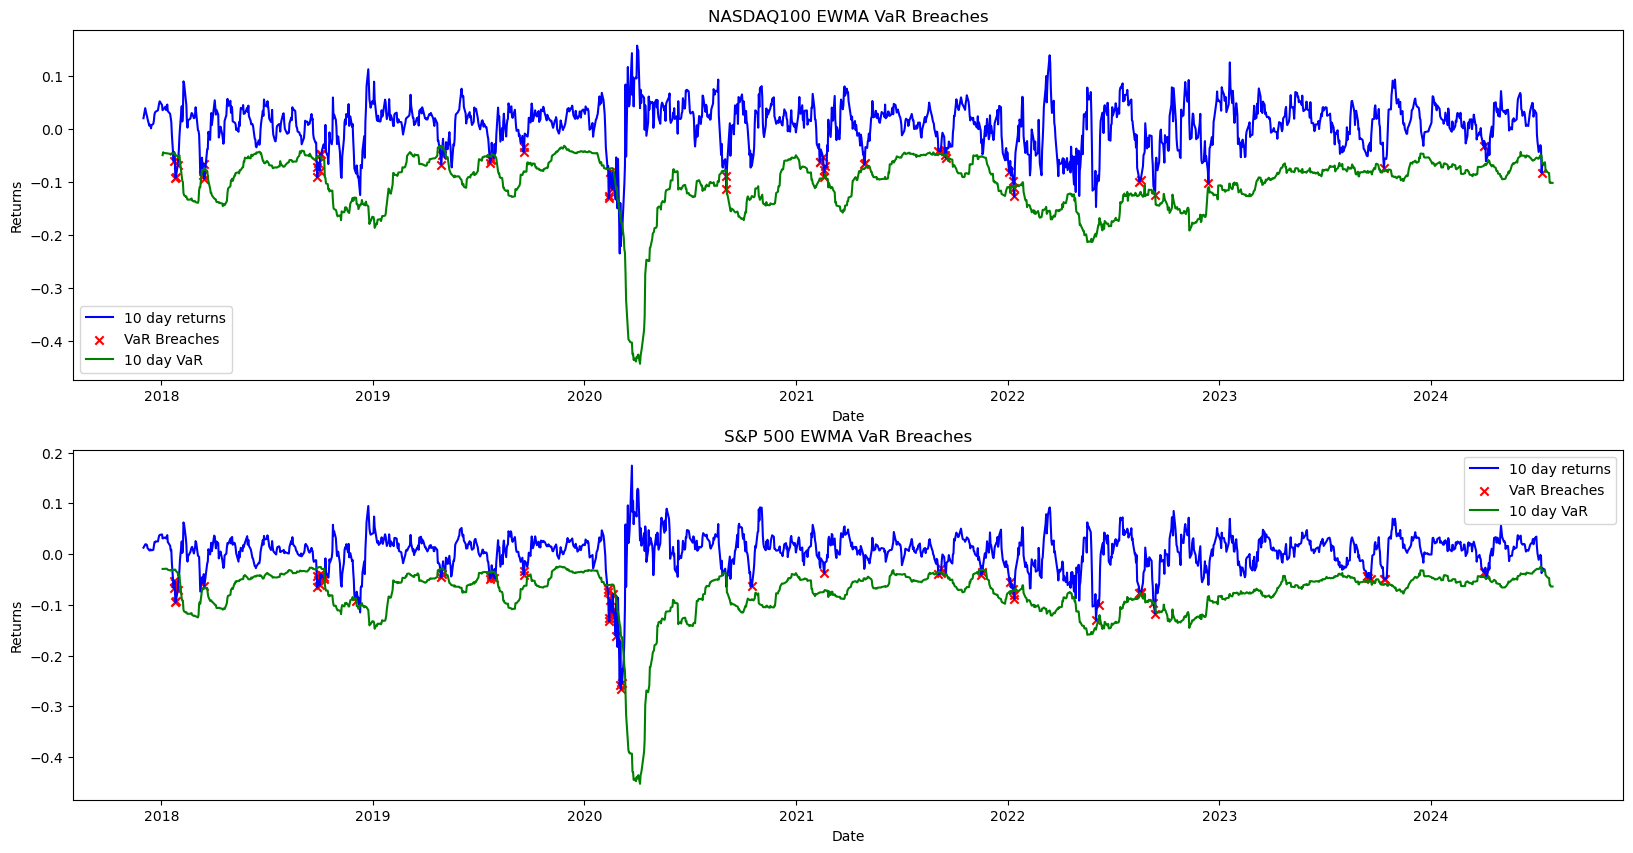

In [ ]:
# Create two subplots so we can compare the S&P500 to the NASDAQ100 VAR breaches
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

# Use our previously defined plotting function  adjusting it to use EWMA breach column
plot_var_breaches(nq100, 'NASDAQ100 EWMA VaR Breaches', 'breach_ewma', ax1)
plot_var_breaches(sp500, 'S&P 500 EWMA VaR Breaches','breach_ewma', ax2)

# Display the plot
plt.show()

In [ ]:
# NASDAQ100 list of VAR breaches
nq100_breach_table = nq100[['Closing Price', 'ret_log', 'ewma_10d', 'ret_10d', 'breach_ewma']]
print('NASDAQ100', nq100_breach_table[nq100_breach_table['breach_ewma']==True].head())


#S&P500 list of VAR breaches
sp500_breach_table = sp500[['Closing Price', 'ret_log', 'ewma_10d', 'ret_10d', 'breach_ewma']]
print('S&P500', sp500_breach_table[sp500_breach_table['breach_ewma']==True].head())

NASDAQ100             Closing Price   ret_log  ewma_10d   ret_10d  breach_ewma
Date                                                                
2018-01-22    6906.279785  0.010473 -0.054253 -0.061257         True
2018-01-25    6916.299805 -0.000441 -0.045599 -0.092363         True
2018-01-26    7022.970215  0.015305 -0.071119 -0.090909         True
2018-01-29    6988.319824 -0.004946 -0.063353 -0.068775         True
2018-03-14    7040.979980 -0.000785 -0.068445 -0.085993         True
S&P500             Closing Price   ret_log  ewma_10d   ret_10d  breach_ewma
Date                                                                
2018-01-22    2832.969971  0.008034 -0.045508 -0.067166         True
2018-01-23    2839.129883  0.002172 -0.039532 -0.052048         True
2018-01-24    2837.540039 -0.000560 -0.033615 -0.056502         True
2018-01-25    2839.250000  0.000602 -0.028620 -0.095363         True
2018-01-26    2872.870117  0.011772 -0.051925 -0.092309         True


In [36]:
# Filter for only breaches
nq100_breach_table = nq100_breach_table[nq100_breach_table['breach_ewma']==True]
sp500_breach_table = sp500_breach_table[sp500_breach_table['breach_ewma']==True]

# Filter for covid period
nq100_covid_breaches = nq100_breach_table.loc['2020-02-01':'2020-03-31']
sp500_covid_breaches = sp500_breach_table.loc['2020-02-01':'2020-03-31']

# Filter for recovery Period
nq100_recovery_breaches = nq100_breach_table.loc['2021-01-01':'2022-12-31']
sp500_recovery_breaches = sp500_breach_table.loc['2021-01-01':'2022-12-31']

# Print number of breaches during each period
print('NASDAQ100 covid EWMA breaches:', 
      len(nq100_covid_breaches), 
      'Recovery EWMA breaches:', 
      len(nq100_recovery_breaches))
print('S&P500 covid EWMA breaches:', 
      len(sp500_covid_breaches), 
      'Recovery EWMA breaches:', 
      len(sp500_recovery_breaches))

NASDAQ100 covid EWMA breaches: 7 Recovery EWMA breaches: 21
S&P500 covid EWMA breaches: 13 Recovery EWMA breaches: 18


 λ impacts the smoothness of predicted EWMA volatility: The higher the λ the more weight is being given to the most recent variance, and less to the most recent return. Volatility tends to cluster together while returns follow a random walk, therefore giving more weight (higher λ) to the most recent variance results in a smoother predicted volatility.